# 理解强化学习模型和贝叶斯在拟合反应时上的差异

在使用强化学习模型和贝叶斯模型在拟合反应时上存在较大的差异，本 notebook 旨在探索这个差异存在的原因。

当前提出几个假设及对应的验证方式：

- 由于强化学习模型在 S 与 V 条件下拟合得到的比例不同，导致在线性模型条件下与 RT 不一致
    - 查看多个被试 RT ，r_from_bayesian，r_from_reinfocementlearning 随时间变化的模式
- 由于变量的细小抖动导致拟合的差异性
    - 对每个 MC/MI 条件下进行分段探索

观察AIC的结果，可以明确在单个被试的水平上，典型的：

- 2，7 号被试在强化学习模型上估计的更好
- 10，12号在贝叶斯模型上估计的更好

因此我们将他们单独挑出来进行探索

## 0. 分析环境准备与数据准备

In [30]:
library(tidyverse)
library(here)

In [31]:
sub_list <- c(2, 7, 10, 18, 34)

# read data with bayesian sr learner
sub_data_all <- read_csv(here("data", "input",
                             "all_data_with_sr_bayesian_learner_scaled.csv"))
sub_data <- filter(sub_data_all, Subject_num %in% sub_list)

New names:
* `` -> ...1

Rows: 30148 Columns: 35

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): stim_color, stim_loc, Type, Subject, logfile_name, condition, fact...
dbl (26): ...1, X.1, column_label, X, Response, RT, Trial, prop, block, time...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [32]:
sub_data

...1,X.1,column_label,X,stim_color,stim_loc,Type,Response,RT,Subject,⋯,ll,lr,rl,rr,v,r_selected,VxPE,scaled_v,scaled_VxPE,PE
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
961,961,2,960,green,left,hit,1,777.8,sub02_liSihong,⋯,0.3097523,0.6902477,0.6025917,0.3974083,4.751605,0.6902477,1.471821,0.1345208,0.04166812,0.3097523
962,962,2,961,green,right,hit,1,640.9,sub02_liSihong,⋯,0.3034909,0.6965091,0.6049089,0.3950911,4.751835,0.3950911,2.874427,0.1348159,0.08155135,0.6049089
963,963,2,962,red,right,hit,0,447.6,sub02_liSihong,⋯,0.2964209,0.7035791,0.6141813,0.3858187,4.751398,0.6141813,1.833178,0.1342551,0.05179813,0.3858187
964,964,2,963,red,right,hit,0,654.6,sub02_liSihong,⋯,0.2905881,0.7094119,0.6186043,0.3813957,4.751652,0.6186043,1.812260,0.1345815,0.05132881,0.3813957
965,965,2,964,red,right,hit,0,403.6,sub02_liSihong,⋯,0.2832291,0.7167709,0.6203166,0.3796834,4.751115,0.6203166,1.803919,0.1338930,0.05083695,0.3796834
966,966,2,965,green,right,hit,1,408.8,sub02_liSihong,⋯,0.2763750,0.7236250,0.6163040,0.3836960,4.749624,0.3836960,2.927212,0.1319810,0.08134040,0.6163040
967,967,2,966,red,right,hit,0,473.6,sub02_liSihong,⋯,0.2693663,0.7306337,0.6195943,0.3804057,4.750247,0.6195943,1.807021,0.1327801,0.05051032,0.3804057
968,968,2,967,red,right,hit,0,510.7,sub02_liSihong,⋯,0.2622592,0.7377408,0.6188722,0.3811278,4.749817,0.6188722,1.810287,0.1322286,0.05039600,0.3811278
969,969,2,968,green,left,hit,1,451.6,sub02_liSihong,⋯,0.2557277,0.7442723,0.6136046,0.3863954,4.750103,0.7442723,1.214733,0.1325949,0.03390817,0.2557277


In [33]:
beh_data <- select(sub_data, stim_color : run)
bayesian_sr_learner_data <- select(sub_data, Subject_num, ll : PE)

In [34]:
# Read data from 2a1d1e data
RLCC_data_path <- '/Users/dddd1007/project2git/cognitive_control_model/ref_code/Lingwang_CCC/model_results_block/RLCC_model_results_SR_Q_D_V_WOB_sub_'

RLCC_all_data <- list()
count <- 1
for (i in sub_list) {
    file_path <- paste0(RLCC_data_path, as.character(i), ".csv")
    print(file_path)
    tmp_dataframe <- cbind(read.csv(file_path), Subject_num = i)
    RLCC_all_data[[count]] <- tmp_dataframe
    count <- count + 1
}


[1] "/Users/dddd1007/project2git/cognitive_control_model/ref_code/Lingwang_CCC/model_results_block/RLCC_model_results_SR_Q_D_V_WOB_sub_2.csv"
[1] "/Users/dddd1007/project2git/cognitive_control_model/ref_code/Lingwang_CCC/model_results_block/RLCC_model_results_SR_Q_D_V_WOB_sub_7.csv"
[1] "/Users/dddd1007/project2git/cognitive_control_model/ref_code/Lingwang_CCC/model_results_block/RLCC_model_results_SR_Q_D_V_WOB_sub_10.csv"
[1] "/Users/dddd1007/project2git/cognitive_control_model/ref_code/Lingwang_CCC/model_results_block/RLCC_model_results_SR_Q_D_V_WOB_sub_18.csv"
[1] "/Users/dddd1007/project2git/cognitive_control_model/ref_code/Lingwang_CCC/model_results_block/RLCC_model_results_SR_Q_D_V_WOB_sub_34.csv"


In [35]:
reinforcement_learning_data <- bind_rows(RLCC_all_data, .id = "column_label")

## 1. 强化学习在 s-v 条件下拟合的比例与贝叶斯不同导致的结果差异

In [36]:
RT_with_llrr <- data.frame(RT = sub_data$RT,
                          sub = sub_data$Subject_num,
                          trials = sub_data$Trial,
                          bl_llrr = ((bayesian_sr_learner_data$ll + bayesian_sr_learner_data$rr) / 2),
                          rl_llrr = ((reinforcement_learning_data$Q_ll + reinforcement_learning_data$Q_rr) / 2),
                          condition = sub_data$condition)

In [37]:
RT_with_llrr_long <- pivot_longer(RT_with_llrr, cols = c("RT", "bl_llrr", "rl_llrr"),
                                  names_to = "type", values_to = "value")

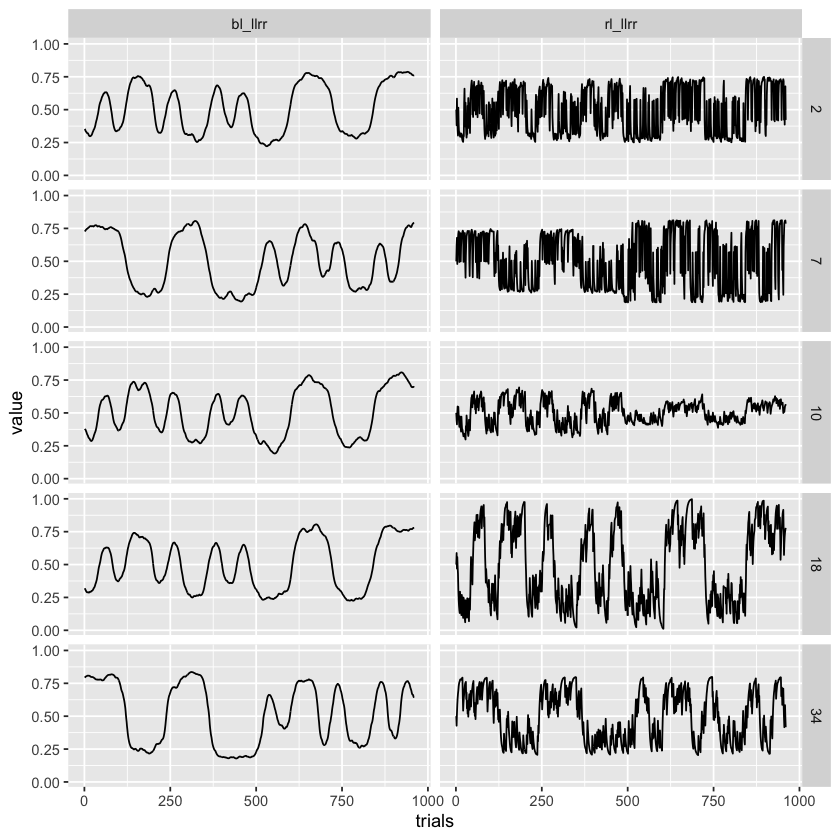

In [38]:
ggplot(filter(RT_with_llrr_long, `type` != "RT")) + geom_line(aes(x = trials, y = value)) + facet_grid(sub~type)

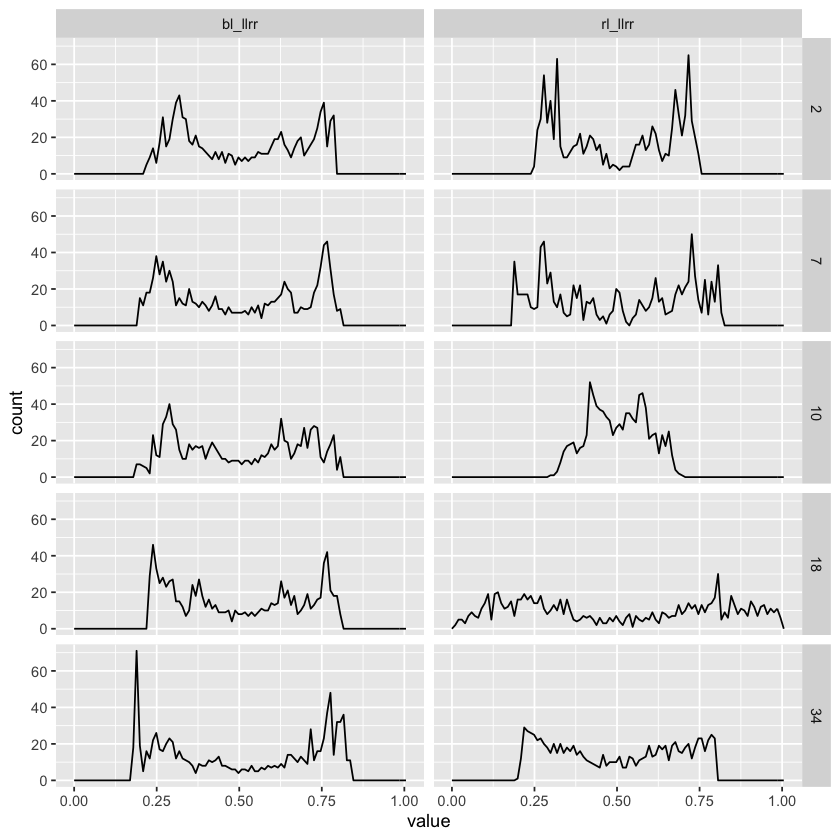

In [39]:
ggplot(filter(RT_with_llrr_long, `type` != "RT")) + geom_freqpoly(aes(value), bins = 100) + facet_grid(sub~type)

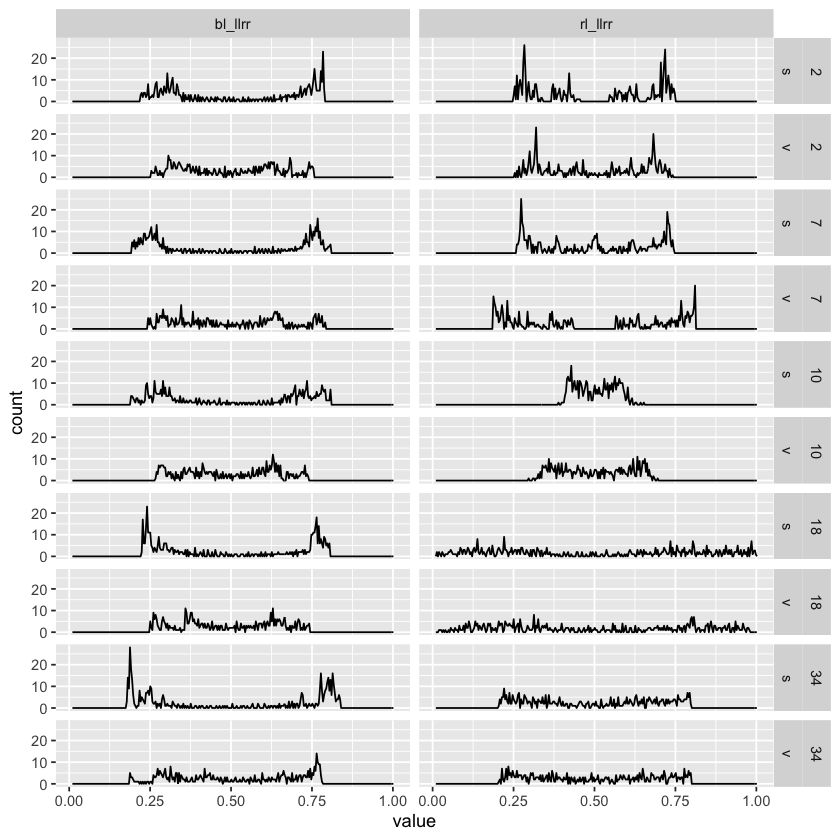

In [40]:
ggplot(filter(RT_with_llrr_long, `type` != "RT")) + geom_freqpoly(aes(value), bins = 300) + facet_grid(sub+condition~type)

## 2. 查看估计值的分布的特征

如果是估计变量的集中程度影响了拟合结果，那么从分布上可以看得出来

In [41]:
RT_with_r <- data.frame(RT = sub_data$RT,
                        sub = sub_data$Subject_num,
                        trials = sub_data$Trial,
                        bl_r = bayesian_sr_learner_data$r_selected,
                        rl_r = reinforcement_learning_data$P,
                        condition = sub_data$condition)
RT_with_r_long <- pivot_longer(RT_with_r, cols = c("RT", "bl_r", "rl_r"), names_to = "type", values_to = "value")


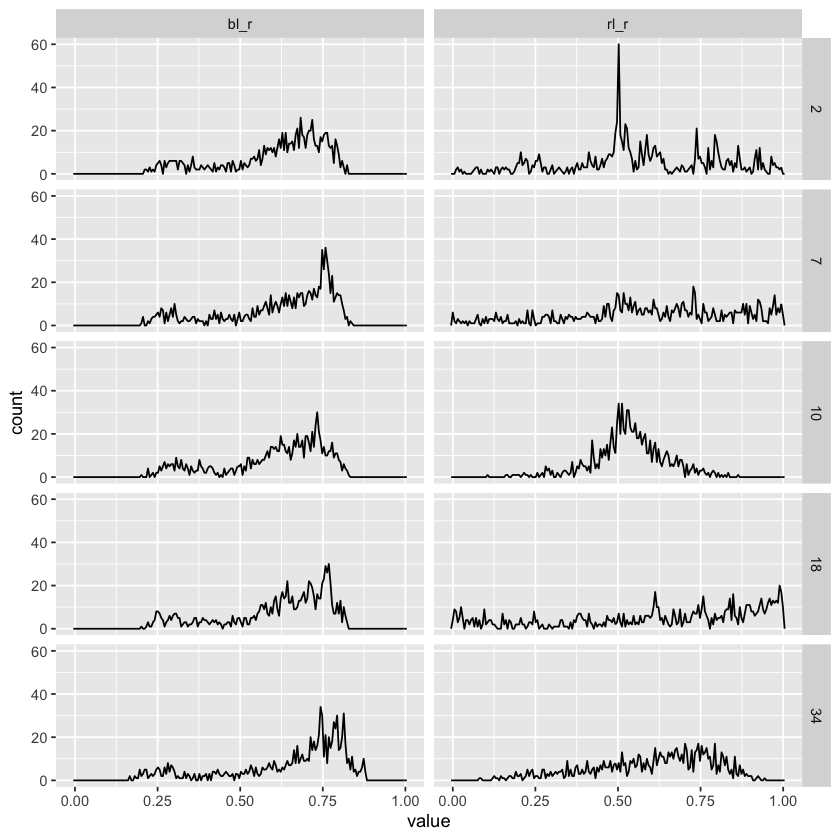

In [42]:
ggplot(filter(RT_with_r_long, `type` != "RT")) + geom_freqpoly(aes(value), bins = 200) + facet_grid(sub~type)

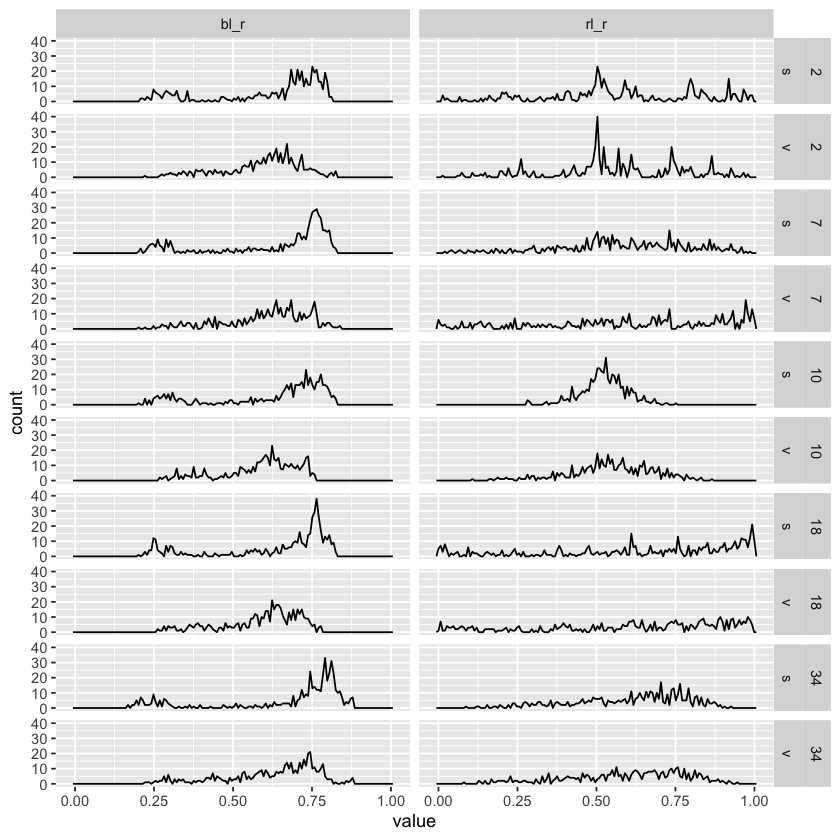

In [43]:
ggplot(filter(RT_with_r_long, `type` != "RT")) + geom_freqpoly(aes(value), bins = 150) + facet_grid(sub+condition~type)

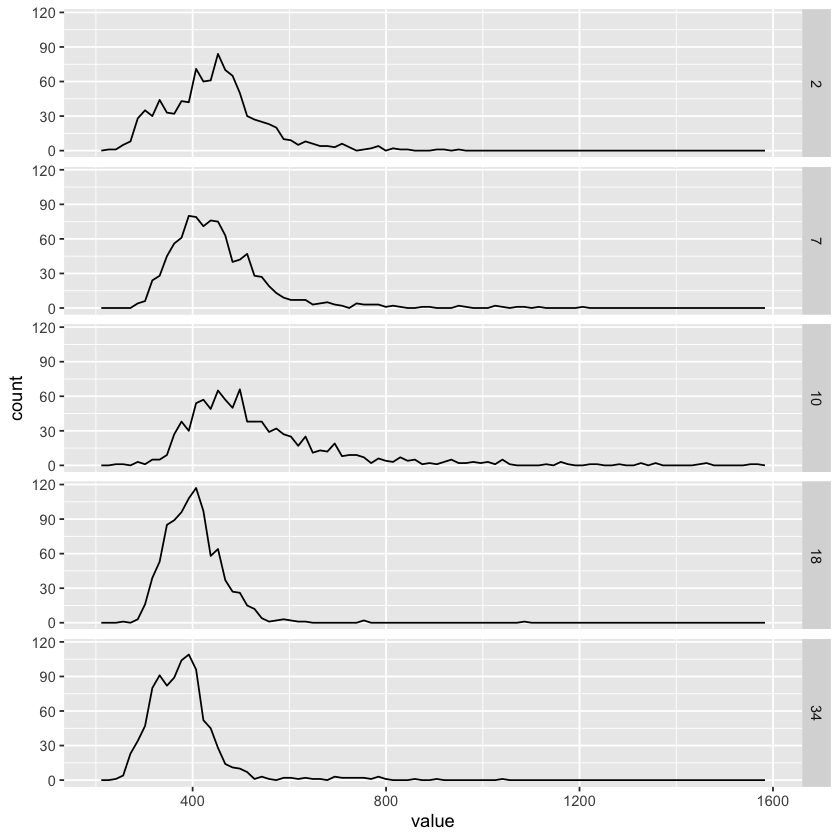

In [44]:
ggplot(filter(RT_with_r_long, `type` == "RT")) + geom_freqpoly(aes(value), bins = 90) + facet_grid(sub~.)

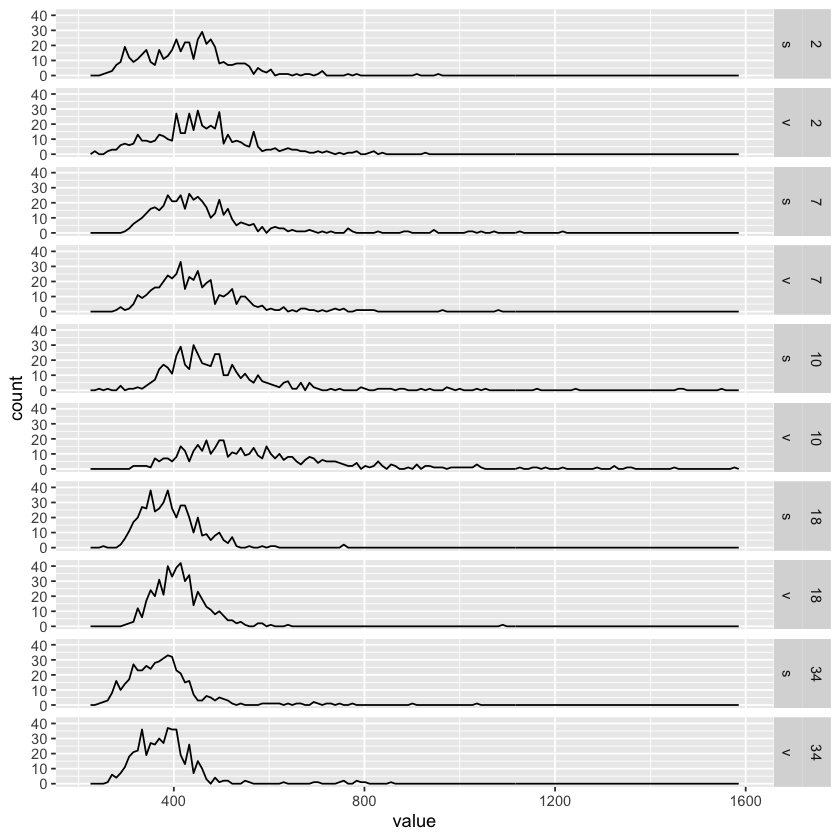

In [45]:
ggplot(filter(RT_with_r_long, `type` == "RT")) + geom_freqpoly(aes(value), bins = 150) + facet_grid(sub+condition~.)

In [46]:
filter(RT_with_r, sub == 10) %>%
    lm(RT ~ bl_r, data = .) %>%
    summary()


Call:
lm(formula = RT ~ bl_r, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-318.48 -103.34  -45.96   54.17 1045.94 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   589.84      22.96  25.695   <2e-16 ***
bl_r          -81.58      36.67  -2.225   0.0263 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 173 on 952 degrees of freedom
Multiple R-squared:  0.005173,	Adjusted R-squared:  0.004128 
F-statistic:  4.95 on 1 and 952 DF,  p-value: 0.02632


In [47]:
filter(RT_with_r, sub == 10) %>%
    lm(RT ~ rl_r, data = .) %>%
    summary()


Call:
lm(formula = RT ~ rl_r, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-313.77 -106.75  -45.77   52.63 1037.52 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   598.88      28.34  21.128   <2e-16 ***
rl_r         -109.51      51.95  -2.108   0.0353 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 173.1 on 952 degrees of freedom
Multiple R-squared:  0.004645,	Adjusted R-squared:  0.003599 
F-statistic: 4.443 on 1 and 952 DF,  p-value: 0.03531


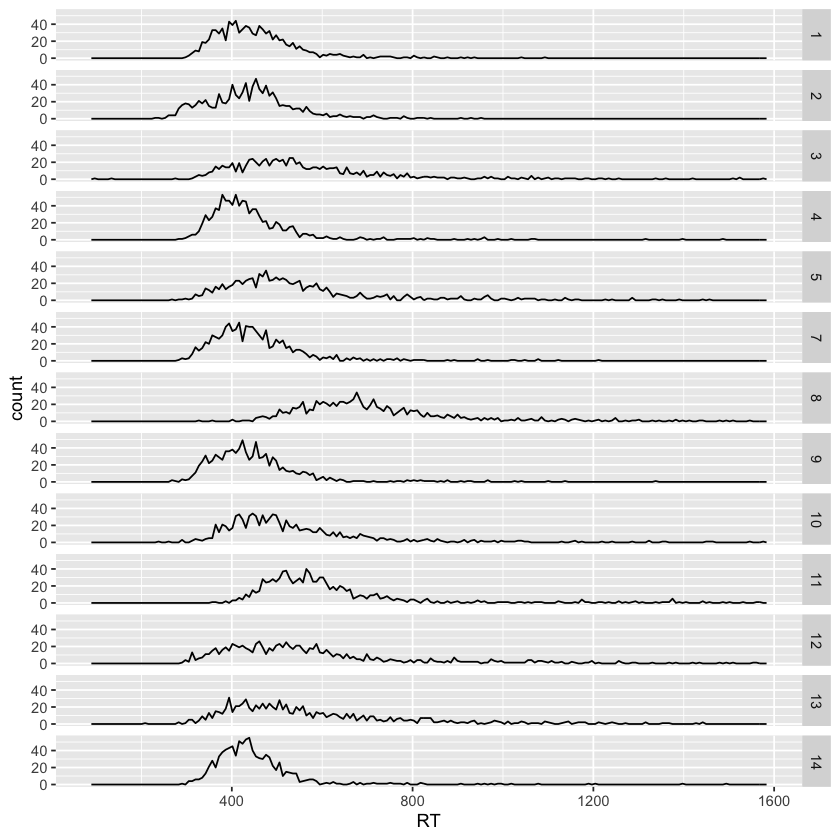

In [48]:
ggplot(filter(sub_data_all, Subject_num < 15)) + geom_freqpoly(aes(RT), bins = 200) + facet_grid(Subject_num~.)

Warning message:
“Ignoring unknown parameters: bins”


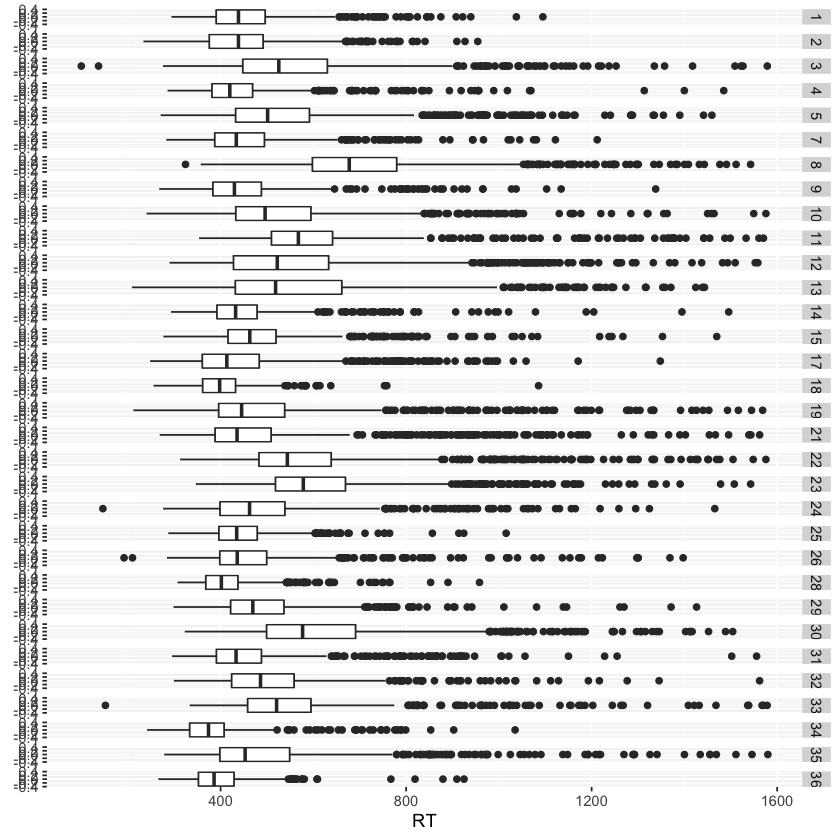

In [49]:
ggplot(sub_data_all) + geom_boxplot(aes(RT), bins = 200) + facet_grid(Subject_num~.)

## 3. 验证是否是数据正态性影响的假设，因强化学习模型基于线性进行估计

In [50]:
library(e1071)
sub_data_all %>%
    group_by(Subject_num) %>%
    summarise(skewness = skewness(RT))

Subject_num,skewness
<dbl>,<dbl>
1,1.8478002
2,0.9783097
3,1.8472988
4,3.6057184
5,1.8733373
7,2.4365012
8,1.5702086
9,2.6030704
10,2.2822491


In [51]:
get_W <- function(data){
    foo <- shapiro.test(data)
    return(foo$statistic)
}

In [52]:
sub_data_all %>%
    group_by(Subject_num) %>%
    summarise(skewness = get_W(RT))

Subject_num,skewness
<dbl>,<dbl>
1,0.8721828
2,0.9497779
3,0.8538795
4,0.7036533
5,0.8319984
7,0.8146109
8,0.8829333
9,0.8038969
10,0.8043070


In [53]:
shapiro.test(sub_data$RT)$statistic[1]

W 
0.7999844

## 4. 考虑是否是估计方式错误导致，查看每个被试的错误率

**好的，并不是**

In [54]:
sub_data_all %>%
    filter(Type != "hit") %>%
    group_by(Subject_num) %>%
    summarise(error_rate = n()/960)

Subject_num,error_rate
<dbl>,<dbl>
1,0.008333333
2,0.025000000
3,0.041666667
4,0.011458333
5,0.005208333
7,0.007291667
8,0.097916667
9,0.023958333
10,0.006250000


## 5. 验证反应时的均值在 s-v 下的变化 

In [55]:
sub_data_all %>%
    group_by(Subject_num, condition) %>%
    summarise(mean_RT = mean(RT)) %>%
    pivot_wider(names_from = condition, values_from = mean_RT)

`summarise()` has grouped output by 'Subject_num'. You can override using the `.groups` argument.



Subject_num,s,v
<dbl>,<dbl>,<dbl>
1,447.3587,462.2433
2,429.2150,458.6685
3,536.2890,601.1857
4,448.0398,439.3601
5,526.1319,567.2095
7,458.1721,449.1335
8,735.1935,690.1726
9,444.4750,453.8562
10,496.4552,584.3506


In [57]:
a <- rnorm(100)
b <- 2*a + rnorm(100)
c <- 1-b

In [58]:
cor.test(a,b)


	Pearson's product-moment correlation

data:  a and b
t = 18.526, df = 98, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8292135 0.9191656
sample estimates:
      cor 
0.8819811 


In [59]:
cor.test(a,c)


	Pearson's product-moment correlation

data:  a and c
t = -18.526, df = 98, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9191656 -0.8292135
sample estimates:
       cor 
-0.8819811 
